# Variational Autoencoders

In this notebook, we will explore how to develop a Variational Autoencoder (VAE). We will define a Variational Autoencoder starting from basic PyTorch components. Then, we will define a training loop which includes the two losses used to train VAEs, namely the reconstruction loss and the KL-divergence loss.

Using this training loop, we will fit the model on the MNIST dataset choosing  appropriate hyperparameters.

Finally, we will and explore and analyze the latent encodings learned by the model thanks to some visualization techniques.

**NOTE**: in order to run this notebook without problems on Google Colab, please connect to a *GPU runtime*. You can do so by clicking on the RAM / Disk icon in the upper right part of the notebook, then on *Change runtime type* at the bottom of the page, and then select the GPU hardware accelerator.


# Requirements

In [ ]:
!pip3 install datasets skorch pandas~=1.5 torch~=1.13 torchinfo torchdata~=0.5 torchtext~=0.14 torchvision~=0.14 torchaudio~=0.13 

# Imports

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore")

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Loading and Preprocessing

We load the MNIST dataset. The dataset contains 60,000 training grayscale images and 10,000 testing image of handwritten digits. We chose to use a 128-dimensional batch in order to make the training process reasonably fast.

In [ ]:
Trns = transforms.ToTensor()
def preprocess(img):
  img = Trns(img)
  H, W = img.shape[1:]
  img = img.reshape((H*W, ))
  return img

MNIST = datasets.MNIST(root='./data', train=True, download=True, transform=preprocess)

In [5]:
batch_size = 128
dataloader = DataLoader(MNIST, batch_size=batch_size, shuffle=True)

Let us see one of the digits:

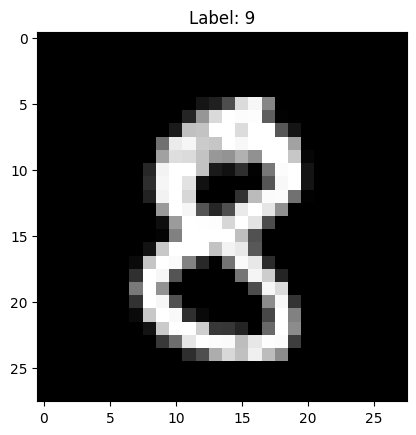

In [6]:
data_iter = iter(dataloader)
images, labels = next(data_iter)

plt.imshow(images[0].reshape(28,28), cmap='gray')
plt.title(f"Label: {labels[0]+1}")
plt.show()

# VAE Architecture

### Variational Autoencoder: reparameterization trick

To implement a VAE we have to define two main parts: the _Encoder_ and the _Decoder_.

Let's start by the Encoder, that computes an encoding of the input from which it computes the mean and the average of the sample distribution.

Once we have these two statistics, we have to implement the sampling phase. Keras does not provide any predefined method to perform this operation, therefore we have to define it. With the aim to be consistent with the layer-composition paradigm used by Keras in defining a model, we define a Sampling layer as a new layer.

In our case, the Sampling layer has in input the tuple made of the mean and the log-variance, and it has to compute the sample $z$ from them by exploiting the reparameterization trick:
$$
z=z_{mean} + exp(z_{var}/2) * \epsilon
$$
The reparameterization trick is used in VAE because it actually helps in the backpropagation process. Specifically, $\epsilon \sim \mathcal{N}(0,1)$ actually reparameterizes our VAE network. This allows the mean and log-variance vectors to still remain as the learnable parameters of the network while maintaining the stochasticity of the entire system via epsilon.

We will complete the code of the VAE model in PyTorch defining:

1. the dense layers that model `z_mean` and `z_var`
2. the sampling function that implements the reparametrization trick
3. the reparameterization trick in the forward function.

The Encoder and Decoder are embodied by the `E_layers` and `D_layers` respectively.


In [15]:
class VAE(nn.Module):
  def __init__(self, input_dim, ENC_LAYERS, latent_dim, DEC_LAYERS, act_fun, last_layer_act_fun):
    super().__init__()
  
    self.E_layers = nn.ModuleList()
    self.D_layers = nn.ModuleList()
    self.latent_dim = latent_dim

    activation_functions = {'linear':transforms.Lambda(lambda x: x), 'sigmoid':F.sigmoid, 'relu':F.relu, 'tanh': F.tanh, 'leaky_relu': F.leaky_relu}
    assert act_fun in activation_functions, f'Activation Functions: {activation_functions.keys()}'
    self.af = activation_functions[act_fun]
    self.last_af = activation_functions[last_layer_act_fun]

    for layer_idx in range(len(ENC_LAYERS)):
      if layer_idx == 0:  # first layer, from input to enc
        self.E_layers = self.E_layers.append(nn.Linear(input_dim, ENC_LAYERS[layer_idx]))
      else:  # hidden layers, depending on the input
        self.E_layers = self.E_layers.append(nn.Linear(ENC_LAYERS[layer_idx-1], ENC_LAYERS[layer_idx]))
    
    # 1. define the dense layers that model z_mean and z_var
    self.linear_mean = nn.Linear(ENC_LAYERS[-1],latent_dim)
    self.linear_var = nn.Linear(ENC_LAYERS[-1],latent_dim)

    if len(DEC_LAYERS) == 0:
      self.D_layers = self.D_layers.append(nn.Linear(ENC_LAYERS[-1], input_dim))
    else:
      for layer_idx in range(len(DEC_LAYERS)):
        if layer_idx == 0:  # first layer, from enc to dec
          self.D_layers = self.D_layers.append(nn.Linear(latent_dim, DEC_LAYERS[layer_idx]))
        else:  # hidden layers, depending on the input
          self.D_layers = self.D_layers.append(nn.Linear(DEC_LAYERS[layer_idx-1], DEC_LAYERS[layer_idx]))

    self.final_fc = nn.Linear(DEC_LAYERS[-1], input_dim)
  
  def sampling(self, z_mean, z_var):
    # sampling function that implements the reparametrization trick
    z = z_mean + torch.mul(torch.exp(z_var/2), torch.randn(self.latent_dim).to(device))
    return z

  def encode(self, x):
    """This function implmements the encoder part of our VAE.
    It will also be useful to explore the latent space learned after training!
    """
    for layer in self.E_layers:
      x = self.af(layer(x))
    return x

  def decode(self, z):
    """This function implmements the decoder part of our VAE.
    It will also be useful to explore the latent space learned after training!
    """
    for layer in self.D_layers:
      z = self.af(layer(z))
    
    out = self.final_fc(z)

    return self.last_af(out)
  
  def forward(self, x):
    x = self.encode(x)

    # use the linear layers and the sampling function defined above
    # to compute the sample z
    self.z_mean = self.linear_mean(x)
    self.z_var = self.linear_var(x)
    self.z = self.sampling(self.z_mean, self.z_var)

    return self.decode(self.z)

# Loss Functions

Now we have defined the VAE but, since it is a generative model, we have to define an ad-hoc training phase. Specifically, we have to manage the two losses used for this model. Indeed the parameters of a VAE are trained via two loss functions: a reconstruction loss, that forces the decoded samples to match the initial inputs, and a regularization loss that helps to learn  a well-formed latent space, and to reduce overfitting. The regularization loss is handled with the _Kullback-Liebler Divergence_. On the other hand, for the reconstruction loss we will use the _binary cross-entropy_ to compare each feature of a data point to the value in the reconstructed output.

We will now implement the reconstruction loss and the KL-divergence.

In [8]:
#let's define the reconstruction loss...
REC_LOSS = nn.BCELoss()

#..and the Kullback-Liebler Divergence
def KL_LOSS(model):
  loss = torch.mean(- 0.5 * torch.sum(1 + model.z_var - model.z_mean.pow(2) - model.z_var.exp(), dim=1))
  return loss

# Training

We define the training loop. Notice how we set a $\beta$ parameter to weight the combination of the two losses. 

In [9]:
def train(model, optimizer, dataloader, epochs, Beta=1e-3):
  loss_train_rec, loss_train_kl, loss_train = [], [], []

  for epoch in range(epochs):
    model.train()
    n_train_batches, rec_train, kl_train, total_loss_train = 0, 0, 0, 0

    for idx, (img, _) in enumerate(dataloader):
      # reset the gradient for all parameters
      optimizer.zero_grad()
      
      # move the input to currently used device
      img = img.to(device)

      # run the model
      rec_img = model(img)
      
      # compute the loss for this sample
      rec_loss = REC_LOSS(rec_img, img)
      kl_loss = KL_LOSS(model)
      total_loss = rec_loss + Beta * kl_loss

      # accumulate the loss for this epoch
      total_loss_train += total_loss
      rec_train += rec_loss
      kl_train += kl_loss

      # compute the gradients and update weights
      total_loss.backward()
      optimizer.step()

      n_train_batches += 1

    # compute losses for this epoch
    avg_loss_train = total_loss_train/n_train_batches
    avg_rec_loss_train = rec_train/n_train_batches
    avg_kl_loss_train = kl_train/n_train_batches

    # store losses
    loss_train.append(avg_loss_train.item())
    loss_train_rec.append(avg_rec_loss_train.item())
    loss_train_kl.append(avg_kl_loss_train.item())

    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Loss: {avg_loss_train:.8f}", end=' ----- ')
      print(f"Rec Loss: {avg_rec_loss_train:.8f}", end=' ----- ')
      print(f"Effective KL Loss: {Beta * avg_kl_loss_train:.8f}")

  return loss_train, loss_train_rec, loss_train_kl

In [10]:
def plot_losses(loss_train, loss_rec, loss_kl):
  plt.subplot(2, 1, 1)
  plt.grid(True)
  plt.title("Reconstruction Loss")
  plt.plot(loss_rec)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

  print("\n")

  plt.subplot(2, 1, 2)
  plt.title("KL Loss")
  plt.grid(True)
  plt.plot(loss_kl)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

In [86]:
# ENC_LAYERS and DEC_LAYERS should be lists describing the number and size of 
# encoding / decoding layers
input_dim = 28**2
ENC_LAYERS =  [512, 256]
latent_dim = 2
DEC_LAYERS =  [128, 256]
act_fun = 'tanh'
last_layer_act_fun = 'sigmoid'

vae = VAE(input_dim, ENC_LAYERS, latent_dim, DEC_LAYERS, act_fun, last_layer_act_fun).to(device)
summary(vae, input_size=(input_dim, ))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [784]                     --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512]                     401,920
│    └─Linear: 2-2                       [256]                     131,328
├─Linear: 1-2                            [2]                       514
├─Linear: 1-3                            [2]                       514
├─ModuleList: 1-4                        --                        --
│    └─Linear: 2-3                       [128]                     384
│    └─Linear: 2-4                       [256]                     33,024
├─Linear: 1-5                            [784]                     201,488
Total params: 769,172
Trainable params: 769,172
Non-trainable params: 0
Total mult-adds (M): 405.87
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 3.08
Estimated Total Size

Let's train out model:

In [87]:
lr = 1e-3
epochs = 30

optimizer = torch.optim.Adam(vae.parameters(), lr=lr)

In [88]:
start = timer()
loss_train, loss_rec, loss_kl = train(vae, optimizer, dataloader, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 0.25529912 ----- Rec Loss: 0.25165001 ----- Effective KL Loss: 0.00364925
epoch: 2 -> Loss: 0.21983638 ----- Rec Loss: 0.21523927 ----- Effective KL Loss: 0.00459703
epoch: 3 -> Loss: 0.20924549 ----- Rec Loss: 0.20396976 ----- Effective KL Loss: 0.00527574
epoch: 4 -> Loss: 0.20251216 ----- Rec Loss: 0.19684021 ----- Effective KL Loss: 0.00567188
epoch: 5 -> Loss: 0.19829805 ----- Rec Loss: 0.19240816 ----- Effective KL Loss: 0.00589000
epoch: 6 -> Loss: 0.19495244 ----- Rec Loss: 0.18881732 ----- Effective KL Loss: 0.00613504
epoch: 7 -> Loss: 0.19302924 ----- Rec Loss: 0.18670890 ----- Effective KL Loss: 0.00632036
epoch: 8 -> Loss: 0.19104697 ----- Rec Loss: 0.18439783 ----- Effective KL Loss: 0.00664922
epoch: 9 -> Loss: 0.18911852 ----- Rec Loss: 0.18257463 ----- Effective KL Loss: 0.00654391
epoch: 10 -> Loss: 0.18826397 ----- Rec Loss: 0.18159002 ----- Effective KL Loss: 0.00667400
epoch: 11 -> Loss: 0.18696009 ----- Rec Loss: 0.18016820 ----- Effective KL Los

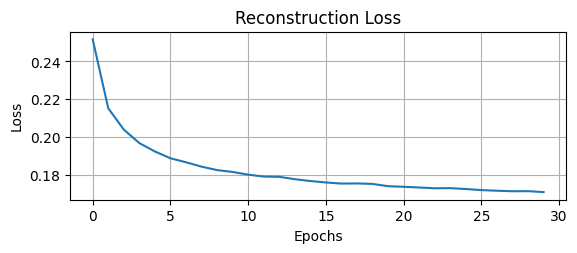

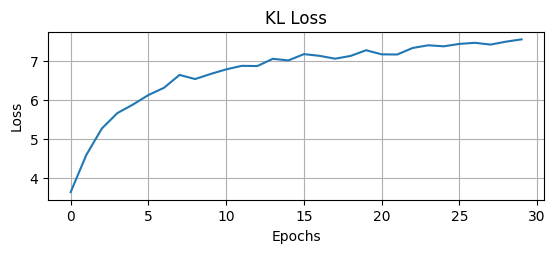

In [89]:
plot_losses(loss_train, loss_rec, loss_kl)

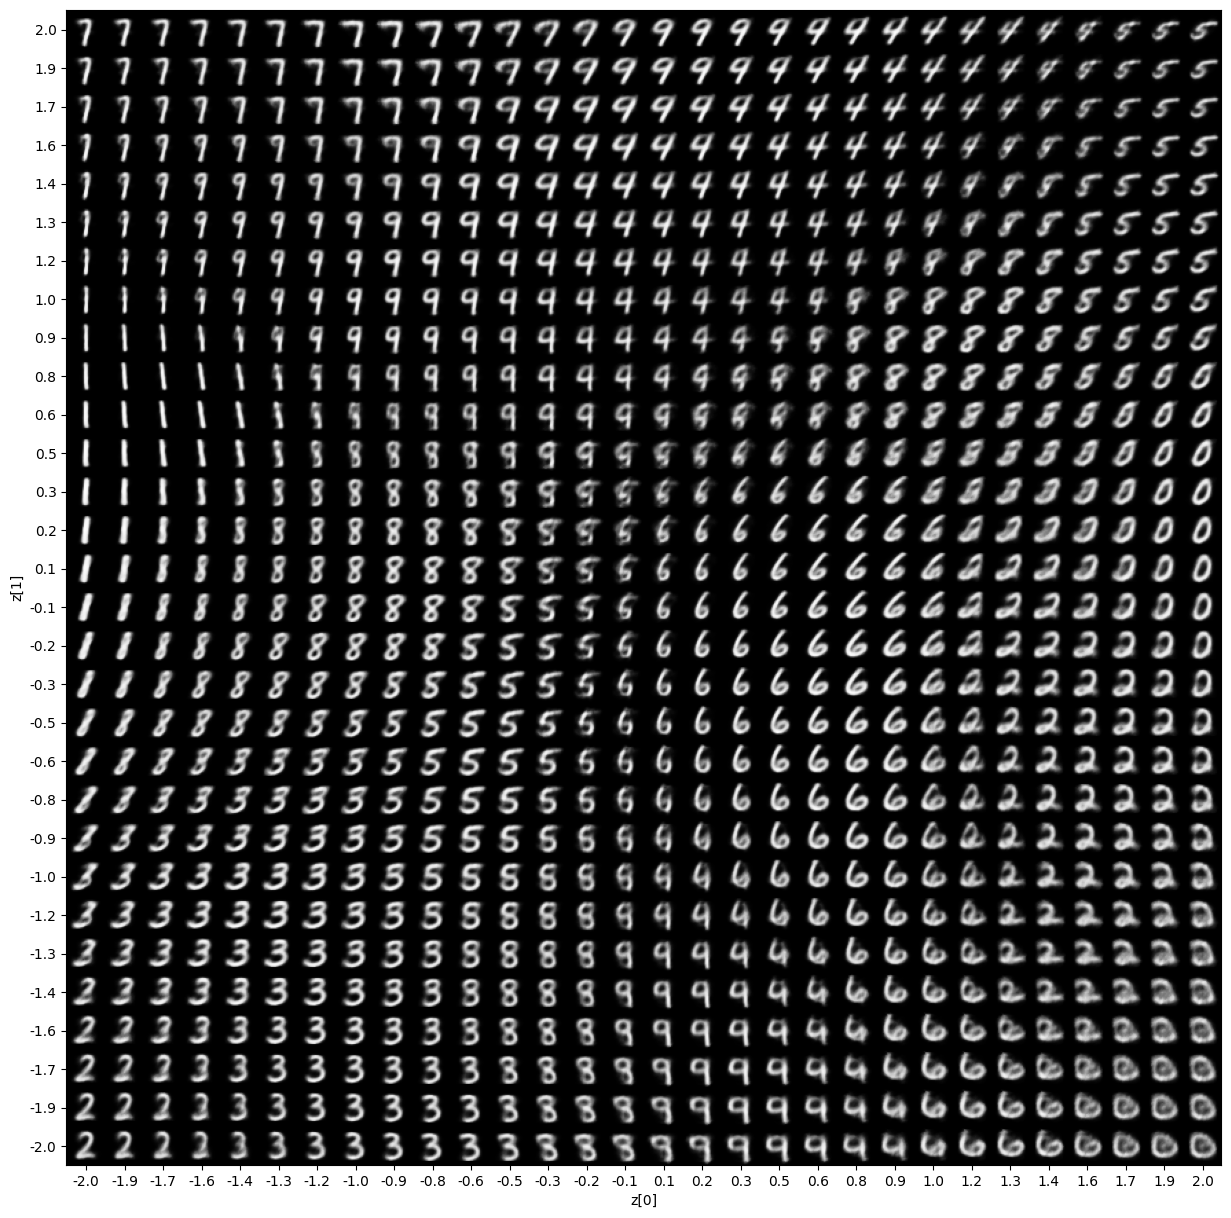

In [90]:
def plot_latent(decoder, scale=2.0, n = 30):
     
    digit_size = 28
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))

    # here we systematically generate 2D samples of z_hat...
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            # ...we cast and reshape the samples
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
            # ...and then we pass them to the decoder, 
            # without keeping track of the gradient
            with torch.no_grad():
              x_decoded = vae.decode(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size).to('cpu')
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    # Finally we plot the generated data
    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)

    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(vae.D_layers, 2.0, 30) 

The final result is quite impressive, considering that all these digits are artificial and they not belong to any dataset!
Let's finally check how the various digits have been represented in the latent space by the VAE.

In [91]:
x_train, y_train = next(iter(DataLoader(MNIST, batch_size=len(MNIST))))

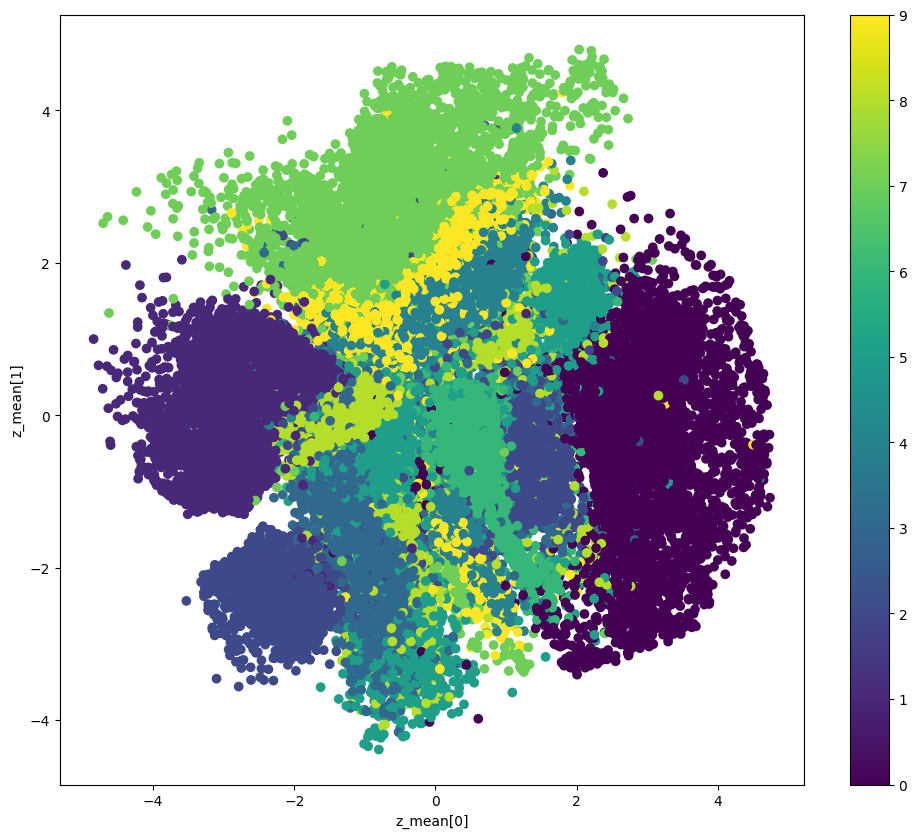

In [92]:
def plot_label_clusters(data, labels):
    with torch.no_grad():
      # let's compute the encodings 
      encoding = vae.encode(data.to(device))
      # and then the mean used in the reparameterization trick
      z_mean = vae.linear_mean(encoding).to('cpu')
    
    # Let's plot the latent space
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z_mean[0]")
    plt.ylabel("z_mean[1]")
    plt.show()

plot_label_clusters(x_train, y_train)